In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
import seaborn as sns
import os
import math
import smtplib

In [30]:
from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [31]:
time_series = pd.read_csv('Electric_Production.csv')
time_series

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


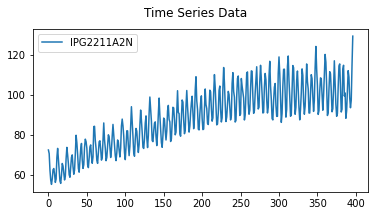

In [32]:
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Time Series Data')
time_series.plot(ax=ax)
plt.show()

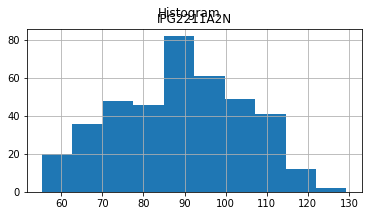

In [33]:
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Histogram')
time_series.hist(ax=ax)
plt.show()

In [34]:
data = time_series['IPG2211A2N']
data

0       72.5052
1       70.6720
2       62.4502
3       57.4714
4       55.3151
         ...   
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Name: IPG2211A2N, Length: 397, dtype: float64

c:\Users\iguv2\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


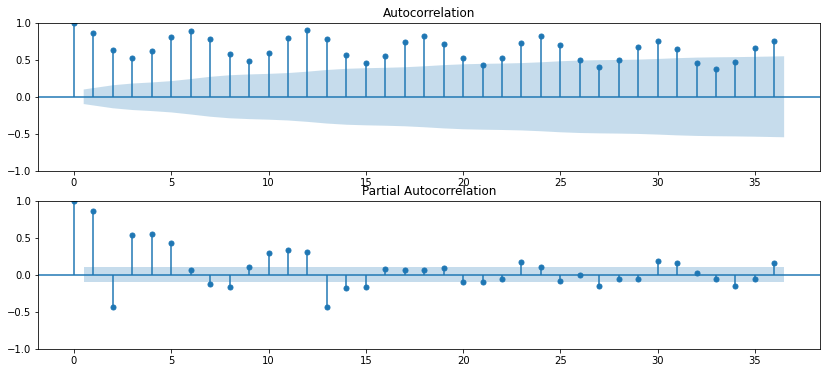

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(data, lags=36, ax=ax1)
ax2 = plot_pacf(data, lags=36, ax=ax2)
plt.show()

In [36]:
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.256990
p-value: 0.186215
Critical Test Statistics Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


# Not Stationary

Since the dataset is shown not to be stationary, try differenciating it to make it stationary.

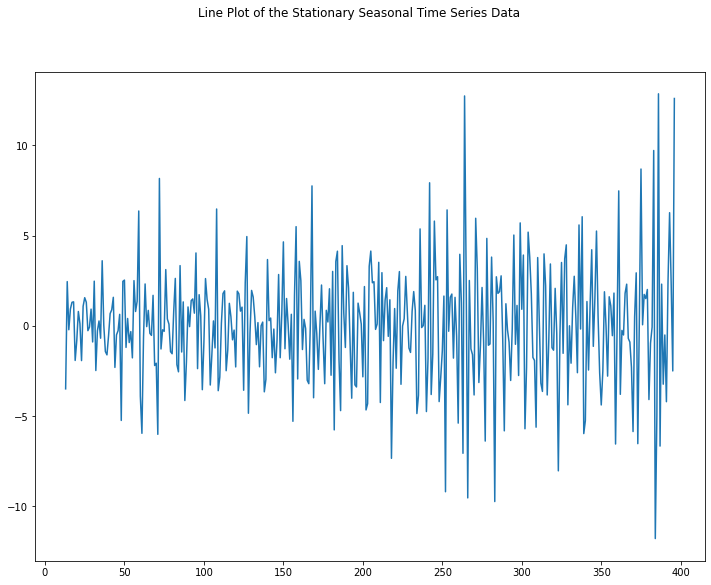

In [37]:
data_diff = data.diff().diff(12)
data_diff.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
data_diff.plot(ax=ax)
plt.show()

The plot above seems to be much more stationary than the original data, because the dataset does not seem to have a trend and no recognizable pattern either.

In [38]:
result = adfuller(data_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.022039
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


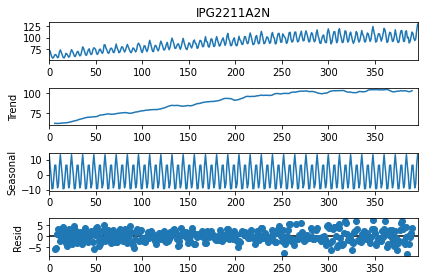

In [39]:
decomp = seasonal_decompose(data,period=12)
decomp.plot()
plt.show()

c:\Users\iguv2\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


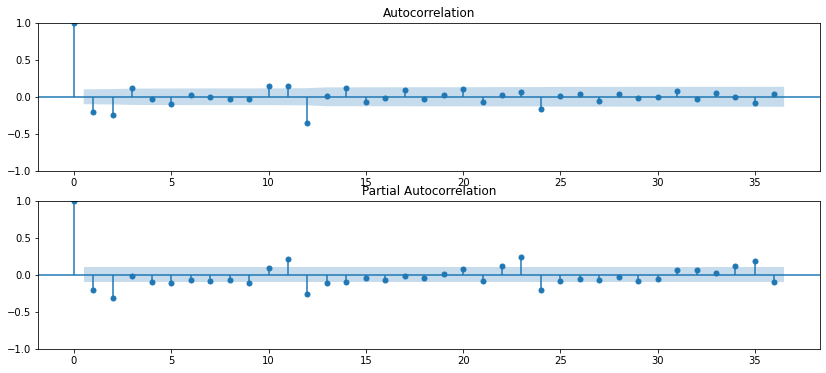

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(data_diff, lags=36, ax=ax1)
ax2 = plot_pacf(data_diff, lags=36, ax=ax2)
plt.show()

1. AR(p) regression model that utilizes dependent relationship between an observation and some number of lagged observations.
2. I(d) is the differencing order to make time series stationary.
3. MA(q) sees observations an residual error and checks correlation between residuals.

원래는 ARIMA 여러 parameter 을 실험하면서 AIC 또는 BIC 파악하면서 해도 좋은데 그냥 자동으로 하자.

# auto_arima function

AIC 가 BIC 에 비해 overfitting penalty 가 낫다. 하지만 사실 그냥 둘 다 사용해서 비교해도 된다. 제일 작은 값을 찾아야한다.

In [41]:
import pmdarima as pm

In [42]:
model = pm.auto_arima(data, d=1, D=1, seasonal=True, m=12, trend='c',start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1865.702, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2012.117, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1942.041, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1837.289, Time=0.97 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1974.343, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1838.537, Time=0.69 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1837.962, Time=3.90 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1925.284, Time=0.44 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1837.164, Time=3.24 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1816.629, Time=3.66 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1825.210, Time=1.81 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1854.602, Time=3.62 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=1770.211, Time=7.64 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=7.22 sec
 ARIMA(1,1,1)(2,1,1)[12]

## Testing The Model.<br>
To test a time series model, the most widely used method is setting the front part as training dataset and back part as testing dataset.

<AxesSubplot:>

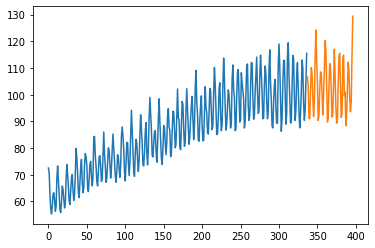

In [43]:
train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]
train.plot()
test.plot()

### Apply the SARIMA model that showed lowest AIC values.
Here, it would be SARIMA(1,1,1)X(2,1,2)(12)

In [44]:
model = SARIMAX(train,order=(1,1,1),seasonal_order=(2,1,2,12))
results = model.fit()
print("Results of SARIMAX on train")
print(results.summary())

Results of SARIMAX on train
                                        SARIMAX Results                                        
Dep. Variable:                              IPG2211A2N   No. Observations:                  337
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -717.382
Date:                                 Tue, 23 Aug 2022   AIC                           1448.764
Time:                                         16:18:18   BIC                           1475.229
Sample:                                              0   HQIC                          1459.328
                                                 - 337                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4993      0.057      8.776   

In [45]:
forecast = results.get_forecast(steps=len(test))
predicts = forecast.predicted_mean
predicts

337    107.511961
338     97.905542
339     88.724545
340     91.157366
341    102.134156
342    111.095059
343    110.664894
344     98.092484
345     90.601502
346     93.216836
347    109.094844
348    116.617130
349    108.026797
350     98.398389
351     88.648555
352     90.648123
353    102.519274
354    111.315113
355    111.109081
356     98.399674
357     90.331654
358     93.008146
359    110.016405
360    116.910857
361    107.530170
362     97.732016
363     88.309079
364     90.661749
365    102.505980
366    111.904166
367    111.173927
368     98.232058
369     90.036628
370     93.088164
371    109.667852
372    116.789834
373    107.002464
374     97.090477
375     88.037691
376     90.745428
377    102.349790
378    112.211870
379    111.058030
380     97.986714
381     89.844345
382     93.144219
383    109.143624
384    116.580544
385    106.702761
386     96.752749
387     87.879213
388     90.749131
389    102.191648
390    112.230779
391    110.908887
392     97

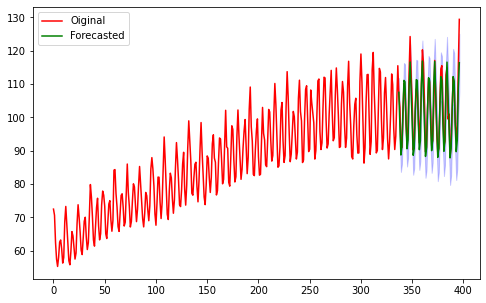

In [49]:
conf_int = forecast.conf_int()
d = predicts.index
plt.figure(figsize=(8,5))
plt.plot(data, label='Oiginal', color = 'red')
plt.plot(d, predicts, label='Forecasted', color= 'green')
plt.fill_between(d, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2, color= 'blue')
plt.legend()
plt.show()

Checking how well our model worked.

In [47]:
from sklearn.metrics import r2_score
print('R2score is',r2_score(test, predicts))
mean_absolute_percentage_error = np.mean(np.abs(predicts - test)/np.abs(test))*100
print('MAPE is', mean_absolute_percentage_error)

R2score is 0.8490685092675972
MAPE is 2.5833347227845853
